In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""This notebook creates the statistics of TAG in Spain in YEAR"""

import inspect, os, sys

try :
    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

except :
    current_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile(inspect.currentframe()))[0]))
    folder_parts = current_folder.split(os.sep)
    pywikibot_folder = os.sep.join(folder_parts[:-1])

    if current_folder not in sys.path:
        sys.path.insert(0, current_folder)
    if pywikibot_folder not in sys.path:
        sys.path.insert(0, pywikibot_folder)

    import pywikibot as pb
    from pywikibot import pagegenerators, textlib
    from pywikibot.specialbots import UploadRobot

import mwparserfromhell as mwh

In [3]:
from modules.wmtools import upload_to_commons, \
                            get_registration_time, \
                            heat_color, \
                            get_project_name, \
                            wrap_label, \
                            coordinate_shaker, \
                            additional_festivals_df

In [4]:
import pandas as pd
import numpy as np
from mako.template import Template
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from urllib.parse import urlencode
import requests
import json
from itertools import groupby
from operator import itemgetter
from functools import reduce
import math
import random

In [5]:
from geojson import Feature, Point, FeatureCollection
import geojson

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pylab

sns.set_style("darkgrid")
%matplotlib inline

In [7]:
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans',
                                  'Bitstream Vera Sans',
                                  'Computer Modern Sans Serif',
                                  'Lucida Grande',
                                  'Verdana',
                                  'Geneva',
                                  'Lucid',
                                  'Arial',
                                  'Helvetica',
                                  'Avant Garde',
                                  'sans-serif']

In [8]:
YEAR                = 2017
TAG                 = 'WLF'
TAG_EXT             = 'Wiki Loves Folk'

BASE_WLF_NAME       = 'Commons:{1}/{0}'.format(YEAR, TAG_EXT)
BASE_WLF2016_NAME   = 'Commons:{1}/{0}'.format(2016, TAG_EXT)
LOG_PAGE            = BASE_WLF_NAME + '/Log'
STATISTICS_PAGE     = BASE_WLF_NAME + '/Stats'
FESTIVAL_DB_PAGE    = BASE_WLF2016_NAME + '/Festival DB'
GALLERY_QI          = BASE_WLF_NAME + '/QI'

VALID_NAMESPACES    = ['0', '4', '100', '104']
DAYS_BEFORE_REGISTRATION = 15

WLF_FINALIST_CATEGORY = "Category:Images from {1} {0} in Spain (finalists)".format(YEAR, TAG_EXT)

commons_site = pb.Site('commons', 'commons')

In [9]:
MW_API_BASE_URL     = 'https://commons.wikimedia.org/w/api.php'
MW_API_QUERY_STRING = {"action": "query",
                       "format": "json",
                       "gulimit": "500",
                       "prop": "globalusage",
                       "guprop": "url|namespace",
                       "titles": None
                      }

In [10]:
figsize=[15., 10.]
figsize_half=[8., 10.]
figsize_high=[15., 30.]
figsize_low=[15., 6.]

In [11]:
cwd = os.getcwd()

images_directory = os.path.join(cwd, 'images')
if not os.path.exists(images_directory):
    os.makedirs(images_directory)
    
templates_directory = os.path.join(cwd, 'templates')

In [12]:
now = (datetime.now().strftime("%Y-%m-%d"))

In [13]:
def get_campaign (row):
    """Function that classifies images according to uploade date.
    THIS IS A YEAR-DEPENDENT FUNCTION"""
    start_datetime_fallas = datetime(YEAR, 3, 1)
    end_datetime_fallas   = datetime(YEAR, 5, 1) + timedelta(hours=2)
    start_datetime_summer = datetime(YEAR, 6, 21)
    end_datetime_summer   = datetime(YEAR, 9, 21) + timedelta(hours=2)
    start_datetime_autumm = datetime(YEAR, 11, 1)
    end_datetime_autumm   = datetime(YEAR, 12, 1) + timedelta(hours=2)
    
    if (row['timestamp'] > start_datetime_fallas) and (row['timestamp'] < end_datetime_fallas):
        return "fallas"
    elif (row['timestamp'] > start_datetime_summer) and (row['timestamp'] < end_datetime_summer):
        return "summer"
    elif (row['timestamp'] > start_datetime_autumm) and (row['timestamp'] < end_datetime_autumm):
        return "autumn"
    else :
        return ""

In [14]:
def expand_itemid (_list):
    new_list = [{"itemid": i, "category": festivals_df[festivals_df['wikidata_id'] == i]['category'].values[0]} for i in _list]
    if len(new_list) > 0:
        new_list = sorted(new_list, key=lambda k: k['category']) 
    return new_list

def decode_list (_list) :
    try:
        new_list = _list[:]
    except :
        new_list = []
    return new_list

In [15]:
def to_geojson (row) :
    reduced_images_df = images_df[(images_df['wikidata_id'] == row['wikidata_id']) & (images_df['width'] > images_df['height'])]
    if len (reduced_images_df.index) == 0:
        reduced_images_df = images_df[images_df['wikidata_id'] == row['wikidata_id']]

    tries = len(reduced_images_df.index) 
    if len(reduced_images_df[reduced_images_df['qi'] == 'qi']) > 0 :
        image = reduced_images_df[reduced_images_df['qi'] == 'qi'].sample(1, random_state=0)['image_title'].values[0]
    elif len(reduced_images_df[reduced_images_df['finalist'] == 'finalist']) > 0 :
        image = reduced_images_df[reduced_images_df['finalist'] == 'finalist'].sample(1, random_state=0)['image_title'].values[0]
    else :
        image = reduced_images_df.sample(1, random_state=0)['image_title'].values[0]

    properties = {"description": "[[File:{0}|150px]]".format(image),
                  "title": "[[:Category:Images of festival with code {0} from {2} {1} in Spain|{3}]]".format(row['wikidata_id'], YEAR, TAG_EXT, row['category']),
                  "marker-size": "small",
                  "marker-symbol": "circle",
                  "marker-color": autcom_colors[row['aut_com']]}
    if row['additional'] == 'additional':
        properties['marker-symbol'] = 'circle-stroked'
    feature = Feature(geometry=Point((row['longitude'], row['latitude'])), 
                      properties=properties
                     )
    return feature

In [15]:
# Image description
plot_description = """== {{{{int:filedesc}}}} ==
{{{{Information
|description={{{{en|{2}}}}}
|source={{{{own}}}}
|author=[[User:Discasto|Discasto]]
|date={3}
}}}}

{{{{Created with Matplotlib}}}}

== {{{{int:license-header}}}} ==
{{{{self|cc-by-sa-4.0}}}}

[[Category:Photos by User:Discasto]]
[[Category:{0} {1} in Spain]]"""

In [37]:
festival_annexes = [
    ['Anexo:Fiestas de interés turístico de Andalucía', 'Andalusia'],
    ['Anexo:Fiestas de interés turístico de Aragón', 'Aragon'],
    ['Anexo:Fiestas de interés turístico de Asturias', 'Asturias'],
    ['Anexo:Fiestas de interés turístico de Cantabria', 'Cantabria'],
    ['Anexo:Fiestas de interés turístico de Castilla-La Mancha', 'Castile-La Mancha'],
    ['Anexo:Fiestas de interés turístico de Castilla y León', 'Castile and León'],
    ['Anexo:Fiestas de interés turístico de Cataluña', 'Catalonia'],
    ['Anexo:Fiestas de interés turístico de la Comunidad de Madrid', 'Community of Madrid'],
    ['Anexo:Fiestas de interés turístico de la Comunidad Valenciana', 'Valencian Community'],
    ['Anexo:Fiestas de interés turístico de Extremadura', 'Extremadura'],
    ['Anexo:Fiestas de interés turístico de las Islas Baleares', 'Balearic Islands'],
    ['Anexo:Fiestas de interés turístico de las Islas Canarias', 'Canary Islands'],
    ['Anexo:Fiestas de interés turístico de Galicia', 'Galicia'],
    ['Anexo:Fiestas de interés turístico de La Rioja', 'La Rioja'],
    ['Anexo:Fiestas de interés turístico de Navarra', 'Navarre'],
    ['Anexo:Fiestas de interés turístico de la Región de Murcia', 'Region of Murcia'],
    ['Anexo:Fiestas y tradiciones del País Vasco', 'Basque Country']
]
annexes = pd.DataFrame(data=festival_annexes, columns=['annex', 'aut_com']).set_index(['aut_com'])['annex']
annexes

aut_com
Andalusia                Anexo:Fiestas de interés turístico de Andalucía
Aragon                      Anexo:Fiestas de interés turístico de Aragón
Asturias                  Anexo:Fiestas de interés turístico de Asturias
Cantabria                Anexo:Fiestas de interés turístico de Cantabria
Castile-La Mancha      Anexo:Fiestas de interés turístico de Castilla...
Castile and León       Anexo:Fiestas de interés turístico de Castilla...
Catalonia                 Anexo:Fiestas de interés turístico de Cataluña
Community of Madrid    Anexo:Fiestas de interés turístico de la Comun...
Valencian Community    Anexo:Fiestas de interés turístico de la Comun...
Extremadura            Anexo:Fiestas de interés turístico de Extremadura
Balearic Islands       Anexo:Fiestas de interés turístico de las Isla...
Canary Islands         Anexo:Fiestas de interés turístico de las Isla...
Galicia                    Anexo:Fiestas de interés turístico de Galicia
La Rioja                  Anexo:Fiestas de 

In [38]:
autcom_palette = [i[1:] for i in sns.color_palette('hls', 17).as_hex()]
autcoms = [i[1] for i in festival_annexes]
autcom_colors = {autcom: autcom_palette[i] for i, autcom in enumerate(autcoms)}
autcom_colors

{'Andalusia': 'db5f57',
 'Aragon': 'db8d57',
 'Asturias': 'dbbc57',
 'Balearic Islands': '578ddb',
 'Basque Country': 'db577e',
 'Canary Islands': '575edb',
 'Cantabria': 'ccdb57',
 'Castile and León': '6edb57',
 'Castile-La Mancha': '9ddb57',
 'Catalonia': '57db6e',
 'Community of Madrid': '57db9d',
 'Extremadura': '57bcdb',
 'Galicia': '7e57db',
 'La Rioja': 'ad57db',
 'Navarre': 'db57db',
 'Region of Murcia': 'db57ac',
 'Valencian Community': '57dbcc'}

In [39]:
pb.output('Retrieving --> {0} in Spain Festivals list from cache'.format(TAG))
festival_list_page = pb.Page(commons_site, FESTIVAL_DB_PAGE)
festival_list_text = StringIO(festival_list_page.text[festival_list_page.text.find('\n') + 1:festival_list_page.text.rfind('\n')])
festivals_df = pd.read_csv(festival_list_text, 
                           sep=";", 
                           index_col=False, 
                           names=['name', 'aut_com', 
                                  'wikidata_id', 'wikidata_timestamp', 
                                  'category', 'cat_timestamp', 'image',
                                  'latitude', 'longitude']
                          )
pb.output('Retrieved --> {0} in Spain Festivals list from cache'.format(TAG))

Retrieving --> WLF in Spain Festivals list from cache
Retrieved --> WLF in Spain Festivals list from cache


In [40]:
festivals_df.head()

,name,aut_com,wikidata_id,wikidata_timestamp,category,cat_timestamp,image,latitude,longitude
0,Carnaval de Cádiz,Andalusia,Q2939698,1.358030e+12,Carnival of Cádiz,1.172166e+12,Carnavaldecadiz.jpg,36.516667,-6.283333
1,Semana Santa en Málaga,Andalusia,Q9075883,1.364769e+12,Holy Week in Málaga,1.262418e+12,"Cristo de La Humillacion y Perdón, Lateral izq...",36.716667,-4.416667
2,Semana Santa de Sevilla,Andalusia,Q1469338,1.356186e+12,Holy Week in Seville,1.270393e+12,Macarena Sevilla-detail.jpg,37.383333,-5.983333
3,Semana Santa en Granada,Andalusia,Q9075873,1.364769e+12,Holy Week in Granada,1.239229e+12,Venerable Hermandad del Santísimo Cristo de la...,37.178056,-3.600833
4,Feria de Abril,Andalusia,Q2918983,1.357986e+12,Feria de Abril,1.148114e+12,Séville-Féria de Abril-1028-1992 05 06.jpg,37.383333,-5.983333


In [41]:
festival_length = len(festivals_df.index)
festival_length

1240

In [42]:
valid_festivals = festivals_df['wikidata_id'].values
valid_festivals

array(['Q2939698', 'Q9075883', 'Q1469338', ..., 'Q23655957', 'Q23655971',
       'Q23655987'], dtype=object)

In [43]:
additional_festivals_df['additional'] = 'additional'
additional_festivals = additional_festivals_df['wikidata_id'].values
additional_festivals

array(['Q47120057', 'Q47119796', 'Q47119479', 'Q12175110', 'Q47128911',
       'Q47129466', 'Q47128318', 'Q5861379'], dtype=object)

In [44]:
additional_festivals_df.head()

,aut_com,category,latitude,longitude,name,wikidata_id,additional
0,Valencian Community,Falles de Dénia,38.840278,0.108611,Fallas de Denia,Q47120057,additional
1,Community of Madrid,Holy Week in Aranjuez,40.033333,-3.602778,Semana Santa de Aranjuez,Q47119796,additional
2,Valencian Community,"Fiesta de la Virgen de Agosto y San Roque, Req...",39.488538,-1.102308,Fiesta de la Virgen de Agosto y San Roque,Q47119479,additional
3,Valencian Community,Gran Fira de València,39.466667,-0.375000,Gran Feria de Valencia,Q12175110,additional
4,Valencian Community,Fiesta en honor de la Virgen de los Desamparad...,39.911738,-0.571874,Fiesta en honor de la Virgen de los Desamparad...,Q47128911,additional


In [45]:
pb.output('Retrieving --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))
list_page = pb.Page(commons_site, LOG_PAGE)
list_page_text = StringIO(list_page.text[list_page.text.find('\n') + 1:list_page.text.rfind('\n')])
images_df = pd.read_csv(list_page_text,
                            sep=";",
                            index_col=False,
                            names=['image_title', 'wikidata_id', 'uploader', 'uploader_registration', 
                                   'timestamp', 'date', 'size', 'height', 'width', 'qi', 'finalist']
                       ).fillna('')
pb.output('Retrieved --> {1} {0} in Spain images list from cache'.format(YEAR, TAG))

images_df['timestamp'] = pd.to_datetime(images_df['timestamp'], format="%Y-%m-%d %H:%M:%S")
images_df['days_from_user_reg'] = images_df.apply(lambda row: (row['timestamp'] - pd.to_datetime(row['uploader_registration'], format="%Y-%m-%d")).days, axis=1)
images_df['days_from_creation'] = images_df.apply(lambda row: (row['timestamp'] - pd.to_datetime(row['date'], format="%Y-%m-%d")).days, axis=1)

images_df['campaign'] = images_df.apply (lambda row: get_campaign(row), axis=1)

images_df.set_index(["timestamp"], inplace=True)
del images_df.index.name

total_images_length = len(images_df)
total_images_length

Retrieving --> WLF 2017 in Spain images list from cache
Retrieved --> WLF 2017 in Spain images list from cache


2542

In [46]:
images_df.groupby(['uploader']).max()['days_from_creation'].sort_values(ascending=False)

uploader
Turol Jones                                5027
Pacopac                                    4389
Vanbasten 23                               3431
Daviibecerril                              2926
Saldeplata                                 2685
Andrelopesnunes2                           2607
Jynus                                      2415
Mishifú                                    1682
Rafesmar                                   1674
Mipaez                                     1585
Susigilabert                               1536
Felix Nieto Gómez                          1474
Pili Soler Garcia                          1448
Egilqui                                    1390
TaronjaSatsuma                             1224
Yumarso                                    1161
Requete6                                   1030
Jfalerog                                    973
Iván Gnell                                  963
Nachegu                                     925
Hameryko                       

In [47]:
qi_list = images_df[images_df['qi'] == 'qi']['image_title']
qi_list

2017-09-10 09:49:28              Algemesí MDS - Recaudando Donativos.jpg
2017-04-01 01:15:37                       Fallas2015 04 Entrada Mora.jpg
2017-04-01 00:49:19    Fallas2017 05 Convento Jerusalen Matematico Ma...
2017-04-01 19:56:24                      Fallas2017 18 Museo Fallero.jpg
2017-04-01 10:18:52              Fallas2017 20 Sueca Literato Azorin.jpg
2017-04-01 23:41:27                           Fallas2017 Mascletà 03.jpg
2017-04-01 23:41:34                           Fallas2017 Mascletà 06.jpg
2017-04-01 20:16:07                             Fallas2017 Ofrena 15.jpg
2017-07-04 16:28:57              Gran Fira Valencia 2016 Correfoc 04.jpg
2018-01-28 15:22:44    SSM17 Desfile Resurreccion IMG 2198 (cropped).jpg
Name: image_title, dtype: object

In [48]:
qi_length = len(qi_list)
qi_length

10

In [49]:
# THIS IS YEAR-DEPENDENT
campaign_count = images_df['campaign'].value_counts()
campaign_count = campaign_count.reindex(['fallas', 'summer', 'autumn'])
campaign_count

fallas     657
summer      75
autumn    1809
Name: campaign, dtype: int64

[[commons:File:WLF 2017 in Spain - Contributions by campaign.png]]


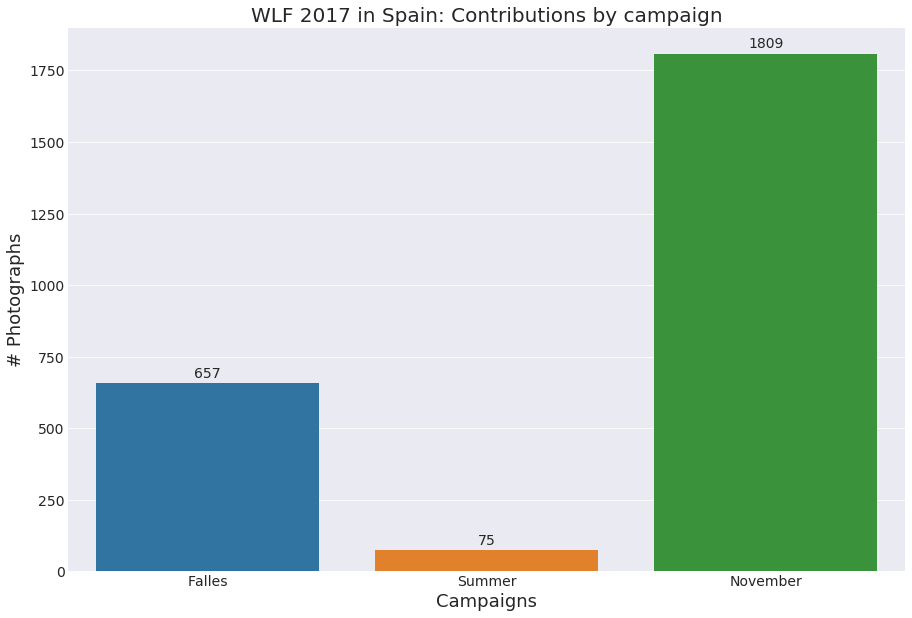

In [29]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=campaign_count.index, y=campaign_count.values)
p.set_xlabel("Campaigns", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(['Falles', 'Summer', 'November'])

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 20,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Contributions by campaign.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [50]:
get_image_wikitext(image_wikitext, 
                                     '{1} {0} in Spain: Contributions by campaign'.format(YEAR, TAG_EXT),
                                    YEAR, TAG_EXT, COUNTRY
                                    )

NameError: name 'COUNTRY' is not defined

In [30]:
uploaders = images_df.groupby(['uploader']).min()['days_from_user_reg']
uploaders

uploader
19Tarrestnom65                             1161
ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"       0
Andrelopesnunes2                              0
Annadctu                                      1
Antonia Marcelo Garcia                        0
Balablanca                                    1
Bgasco                                      445
Calvesklein                                   1
Coentor                                    3298
Daviibecerril                                 0
Dbascones                                   931
Distritofallas                                0
Dorieo                                     3168
EdurNeapoli                                   0
Egilqui                                       0
El Pantera                                 3873
Encar.sp                                      0
Enric                                       710
EnricRodri                                    0
Ernest Alagarda                               0
FallaTioPep                    

In [31]:
days_from_user_reg = uploaders.value_counts().sort_index(ascending=False)
days_from_user_reg

4332     1
4079     1
3873     1
3872     1
3817     1
3298     1
3262     1
3168     1
3028     1
2328     1
2271     1
1288     1
1176     1
1161     1
931      1
915      1
710      1
445      1
429      1
59       1
31       1
1       10
0       34
Name: days_from_user_reg, dtype: int64

In [32]:
age = pd.cut(uploaders, bins=[0, 15, 365, 730, 3650, 5000], include_lowest=True).value_counts()

[[commons:File:WLF 2017 in Spain - Contestant age.png]]


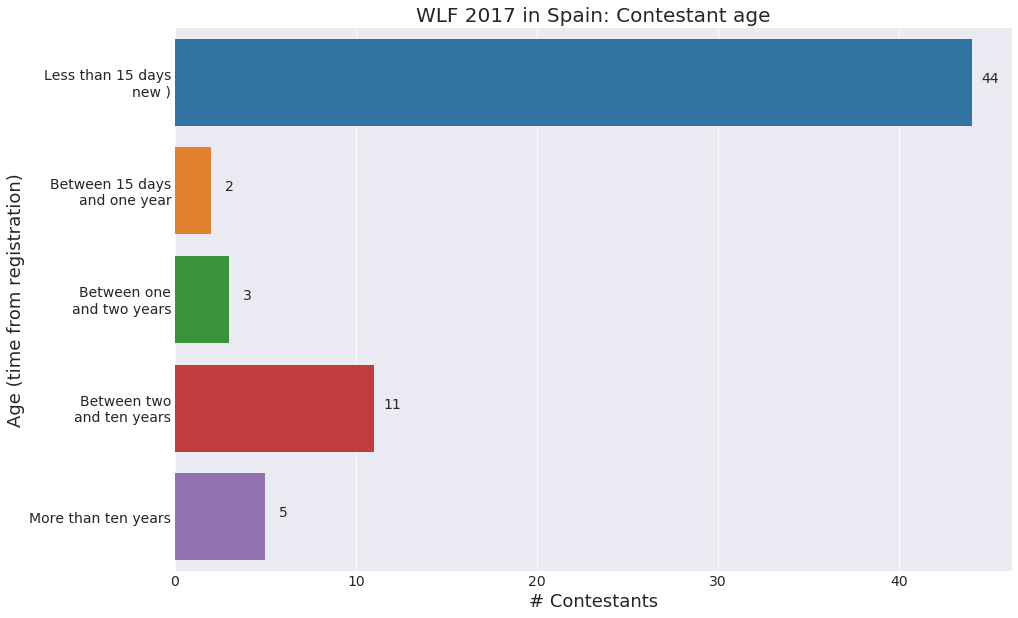

In [33]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=age.index, x=age.values)
p.set_xlabel("# Contestants", fontsize=18)
p.set_ylabel("Age (time from registration)", fontsize=18)

p.set_title(label='{1} {0} in Spain: Contestant age'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_yticklabels(['Less than 15 days\nnew )', 
                   'Between 15 days\nand one year', 
                   'Between one\nand two years', 
                   'Between two\nand ten years', 
                   'More than ten years'])

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Contestant age.png".format(YEAR, TAG),
                  '{1} {0} in Spain: Contestant age. Time from registration to first contribution to contest.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [34]:
authors_length = len(uploaders.index)
authors_length

65

In [35]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader

Turol Jones                                1441
Rafesmar                                    262
Dorieo                                      163
19Tarrestnom65                              142
Jynus                                        68
Millars                                      34
Vanbasten 23                                 31
Rodelar                                      28
Juanjnicolas                                 26
TaronjaSatsuma                               23
Ernest Alagarda                              22
FallaTioPep                                  22
Enric                                        21
Javi.vmc                                     15
Pacopac                                      14
Pedro J Pacheco                              14
Mishifú                                      14
Jfalerog                                     13
Yumarso                                      13
Nelav                                        13
Ponscor                                 

In [36]:
# New uploaders
days_before_registration = DAYS_BEFORE_REGISTRATION
new_uploaders = uploaders[uploaders<days_before_registration].index
new_uploaders

Index(['ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"', 'Andrelopesnunes2',
       'Annadctu', 'Antonia Marcelo Garcia', 'Balablanca', 'Calvesklein',
       'Daviibecerril', 'Distritofallas', 'EdurNeapoli', 'Egilqui', 'Encar.sp',
       'EnricRodri', 'Ernest Alagarda', 'FallaTioPep', 'Felix Nieto Gómez',
       'Iván Gnell', 'J. Fernando Perez Blas', 'Javi.vmc', 'Javixu',
       'Jfalerog', 'Joan Estelrich', 'Jor 1988', 'Juanjnicolas', 'Luifergim',
       'Luis Carcavilla', 'Magina Basallote', 'Maria19731008', 'Mipaez',
       'Mishifú', 'Na Jordana', 'Nachegu', 'NelEwaret', 'Nelav', 'OPINA62',
       'Pablondelpms', 'Pili Soler Garcia', 'Rcasans', 'Requete6', 'Romagir',
       'Sandraluzon92', 'Sebring74', 'Susigilabert', 'Tonovizcainoestevan',
       'Yumarso'],
      dtype='object', name='uploader')

In [37]:
new_uploaders_length = len(new_uploaders)
new_uploaders_length

44

In [38]:
new_uploaders = images_per_uploader[new_uploaders]
new_uploaders

uploader
ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"     4
Andrelopesnunes2                            1
Annadctu                                    5
Antonia Marcelo Garcia                      7
Balablanca                                  1
Calvesklein                                 3
Daviibecerril                               1
Distritofallas                              1
EdurNeapoli                                 3
Egilqui                                     3
Encar.sp                                    1
EnricRodri                                  1
Ernest Alagarda                            22
FallaTioPep                                22
Felix Nieto Gómez                          10
Iván Gnell                                  7
J. Fernando Perez Blas                      1
Javi.vmc                                   15
Javixu                                      4
Jfalerog                                   13
Joan Estelrich                              7
Jor 1988                 

In [39]:
images_per_uploader = images_df['uploader'].value_counts()
images_per_uploader = images_per_uploader.rename('images')
images_per_uploader = images_per_uploader.iloc[np.lexsort([images_per_uploader.index, -images_per_uploader.values])]
images_per_uploader

Turol Jones                   1441
Rafesmar                       262
Dorieo                         163
19Tarrestnom65                 142
Jynus                           68
Millars                         34
Vanbasten 23                    31
Rodelar                         28
Juanjnicolas                    26
TaronjaSatsuma                  23
Ernest Alagarda                 22
FallaTioPep                     22
Enric                           21
Javi.vmc                        15
Mishifú                         14
Pacopac                         14
Pedro J Pacheco                 14
Jfalerog                        13
Nelav                           13
Yumarso                         13
Ponscor                         12
Hameryko                        11
Felix Nieto Gómez               10
Luifergim                       10
NelEwaret                        9
Na Jordana                       8
Antonia Marcelo Garcia           7
Dbascones                        7
Iván Gnell          

In [40]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS = 13

In [41]:
images_per_uploader.size

65

In [42]:
remaining_images_per_uploader_count = images_per_uploader[TOP_UPLOADERS:].count()
remaining_images_per_uploader_count

52

In [43]:
remaining_images_per_uploader_sum = images_per_uploader[TOP_UPLOADERS:].sum()
remaining_images_per_uploader_sum

259

In [44]:
remaining_images_per_uploader = images_per_uploader[:TOP_UPLOADERS]
remaining_images_per_uploader = remaining_images_per_uploader.iloc[np.lexsort([remaining_images_per_uploader.index, -remaining_images_per_uploader.values])]
remaining_images_per_uploader = remaining_images_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_per_uploader_count): remaining_images_per_uploader_sum}))
remaining_images_per_uploader

Turol Jones        1441
Rafesmar            262
Dorieo              163
19Tarrestnom65      142
Jynus                68
Millars              34
Vanbasten 23         31
Rodelar              28
Juanjnicolas         26
TaronjaSatsuma       23
Ernest Alagarda      22
FallaTioPep          22
Enric                21
Rest (52)           259
dtype: int64

[[commons:File:WLF 2017 in Spain - Top authors.png]]


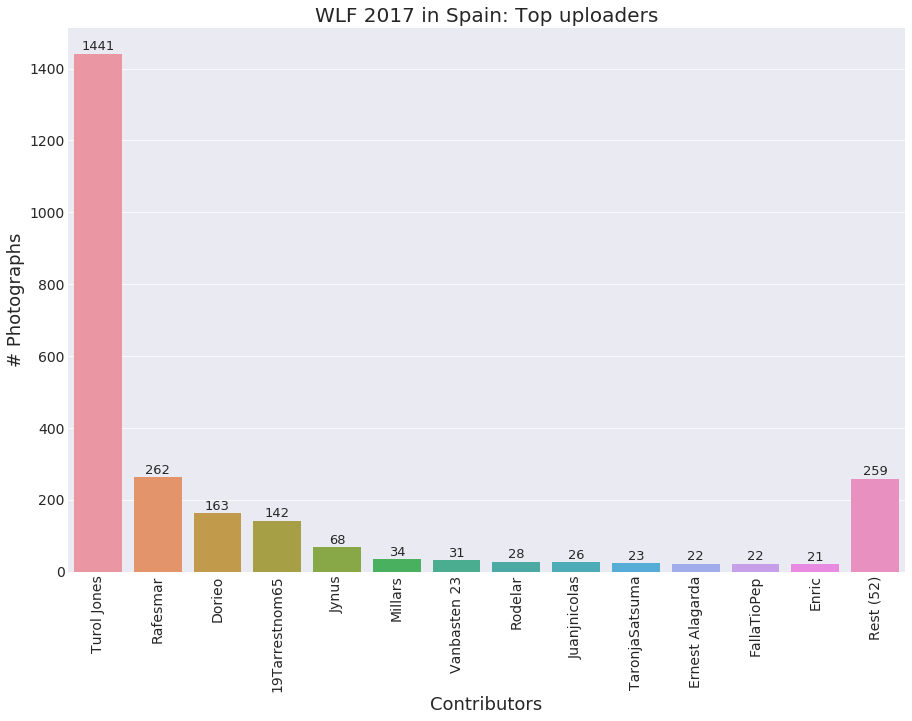

In [45]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_per_uploader.index, y=remaining_images_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [46]:
images_df['uploader'].unique()

array(['Na Jordana', 'Javi.vmc', 'Encar.sp', 'Enric', 'Pacopac',
       'Rafesmar', '19Tarrestnom65', 'Jfalerog', 'OPINA62', 'Jynus',
       'Joan Estelrich', 'Felix Nieto Gómez', 'Turol Jones', 'Annadctu',
       'Sandraluzon92', 'Mishifú', 'Pedro J Pacheco', 'Dbascones',
       'Pablondelpms', 'Javixu', 'Dorieo', 'Millars', 'Rodelar',
       'Calvesklein', 'Vanbasten 23', 'Pili Soler Garcia', 'EnricRodri',
       'Iván Gnell', 'Maria19731008', 'Luis Carcavilla', 'TaronjaSatsuma',
       'Juanjnicolas', 'Ponscor', 'Yumarso',
       'ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"', 'Distritofallas',
       'Rcasans', 'Ernest Alagarda', 'Tonovizcainoestevan', 'Luifergim',
       'Nelav', 'Coentor', 'NelEwaret', 'Nachegu', 'Hameryko', 'Egilqui',
       'Susigilabert', 'Saldeplata', 'Bgasco', 'Andrelopesnunes2',
       'Jor 1988', 'Magina Basallote', 'Antonia Marcelo Garcia',
       'Romagir', 'Gonzalowski', 'El Pantera', 'EdurNeapoli',
       'FallaTioPep', 'Mipaez', 'Daviibecerril', 'Sebring74

In [47]:
images_df['uploader'].unique().size

65

In [48]:
valid_images_length = len(images_df[images_df['wikidata_id'].isin(valid_festivals)].index)
valid_images_length

2383

In [49]:
images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique()

array(['Q1143768', 'Q3290365', 'Q23662027', 'Q829919', 'Q5660198',
       'Q23663612', 'Q20105477', 'Q23658027', 'Q23657061', 'Q23662985',
       'Q5685566', 'Q18696203', 'Q17301586', 'Q23663100', 'Q3181317',
       'Q21479929', 'Q1236370', 'Q23663059', 'Q17632299', 'Q23660880',
       'Q23660934', 'Q23663605', 'Q5815728', 'Q8771143', 'Q23662044',
       'Q23663119', 'Q23663386', 'Q5858861', 'Q4121017', 'Q23661684',
       'Q23650279', 'Q3092925', 'Q13258770', 'Q23657396', 'Q11921892',
       'Q23661532', 'Q4895460', 'Q9075883', 'Q5963233', 'Q7401479',
       'Q6124533', 'Q12874', 'Q5400462', 'Q21003051', 'Q23310019',
       'Q2918983', 'Q23453636', 'Q23453449', 'Q23309364', 'Q23663003',
       'Q17305074', 'Q6024342', 'Q23541308', 'Q9075892', 'Q23309290',
       'Q9075846', 'Q20109030', 'Q23657189'], dtype=object)

In [50]:
festivals_per_uploader_df = images_df[images_df['wikidata_id'].isin(valid_festivals)].\
                                    groupby(['uploader']).\
                                    agg({"wikidata_id": pd.Series.nunique}).\
                                    sort_values('wikidata_id', ascending=False)
festivals_per_uploader = festivals_per_uploader_df["wikidata_id"]
festivals_per_uploader = festivals_per_uploader.rename('festivals')
festivals_per_uploader = festivals_per_uploader.iloc[np.lexsort([festivals_per_uploader.index, -festivals_per_uploader.values])]
festivals_per_uploader

uploader
Dbascones                                  4
Turol Jones                                4
Joan Estelrich                             3
Jynus                                      3
Rafesmar                                   3
TaronjaSatsuma                             3
Egilqui                                    2
Iván Gnell                                 2
Juanjnicolas                               2
Mishifú                                    2
Pedro J Pacheco                            2
Rodelar                                    2
Vanbasten 23                               2
Yumarso                                    2
19Tarrestnom65                             1
ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"    1
Andrelopesnunes2                           1
Annadctu                                   1
Antonia Marcelo Garcia                     1
Balablanca                                 1
Bgasco                                     1
Calvesklein                                1
C

In [51]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
TOP_UPLOADERS_BY_FESTIVAL = 14

In [52]:
images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique()

array(['Q1143768', 'Q3290365', 'Q23662027', 'Q829919', 'Q5660198',
       'Q23663612', 'Q20105477', 'Q23658027', 'Q23657061', 'Q23662985',
       'Q5685566', 'Q18696203', 'Q17301586', 'Q23663100', 'Q3181317',
       'Q21479929', 'Q1236370', 'Q23663059', 'Q17632299', 'Q23660880',
       'Q23660934', 'Q23663605', 'Q5815728', 'Q8771143', 'Q23662044',
       'Q23663119', 'Q23663386', 'Q5858861', 'Q4121017', 'Q23661684',
       'Q23650279', 'Q3092925', 'Q13258770', 'Q23657396', 'Q11921892',
       'Q23661532', 'Q4895460', 'Q9075883', 'Q5963233', 'Q7401479',
       'Q6124533', 'Q12874', 'Q5400462', 'Q21003051', 'Q23310019',
       'Q2918983', 'Q23453636', 'Q23453449', 'Q23309364', 'Q23663003',
       'Q17305074', 'Q6024342', 'Q23541308', 'Q9075892', 'Q23309290',
       'Q9075846', 'Q20109030', 'Q23657189'], dtype=object)

In [53]:
wlf_festivals_length = images_df[images_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].unique().size
wlf_festivals_length

58

[[commons:File:WLF 2017 in Spain - Top authors by festival.png]]


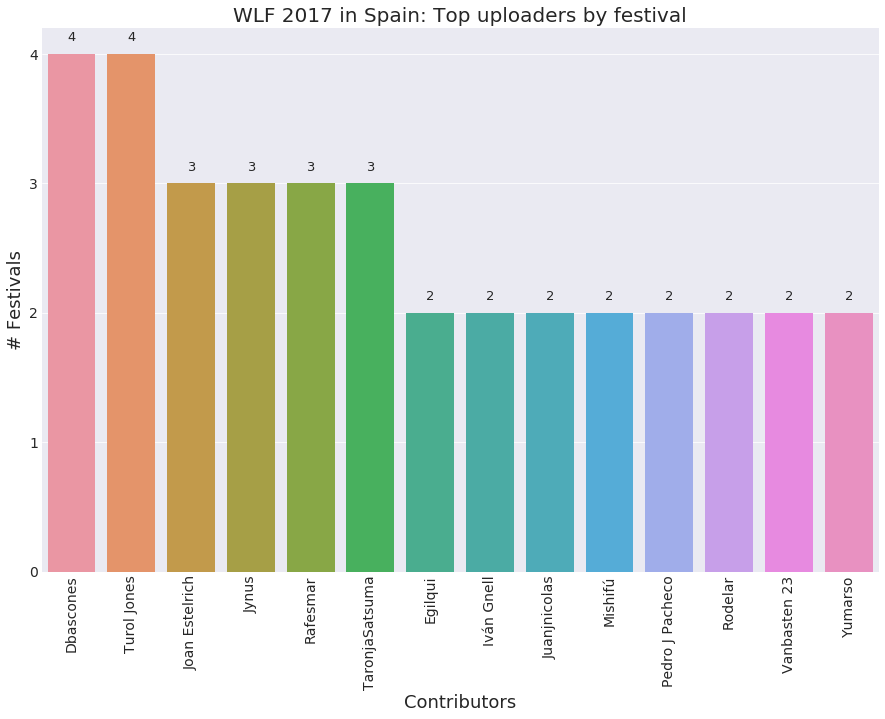

In [54]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=festivals_per_uploader[:TOP_UPLOADERS_BY_FESTIVAL].index, 
                y=festivals_per_uploader[:TOP_UPLOADERS_BY_FESTIVAL].values
               )
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders by festival'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)
p.yaxis.set_major_locator(MaxNLocator(integer=True))

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors by festival.png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_UPLOADERS_BY_FESTIVAL),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [55]:
uploaders_df = pd.concat([festivals_per_uploader, images_per_uploader], axis=1).fillna(0)
uploaders_df.columns=['Festivals', 'Photographs']
uploaders_df['Festivals'] = uploaders_df['Festivals'].astype(int)
uploaders_df = uploaders_df.iloc[np.lexsort([uploaders_df.index, -uploaders_df['Photographs']])]
uploaders_df

,Festivals,Photographs
Turol Jones,4,1441
Rafesmar,3,262
Dorieo,1,163
19Tarrestnom65,1,142
Jynus,3,68
Millars,1,34
Vanbasten 23,2,31
Rodelar,2,28
Juanjnicolas,2,26
TaronjaSatsuma,3,23


[[commons:File:WLF 2017 in Spain - Top authors (2).png]]


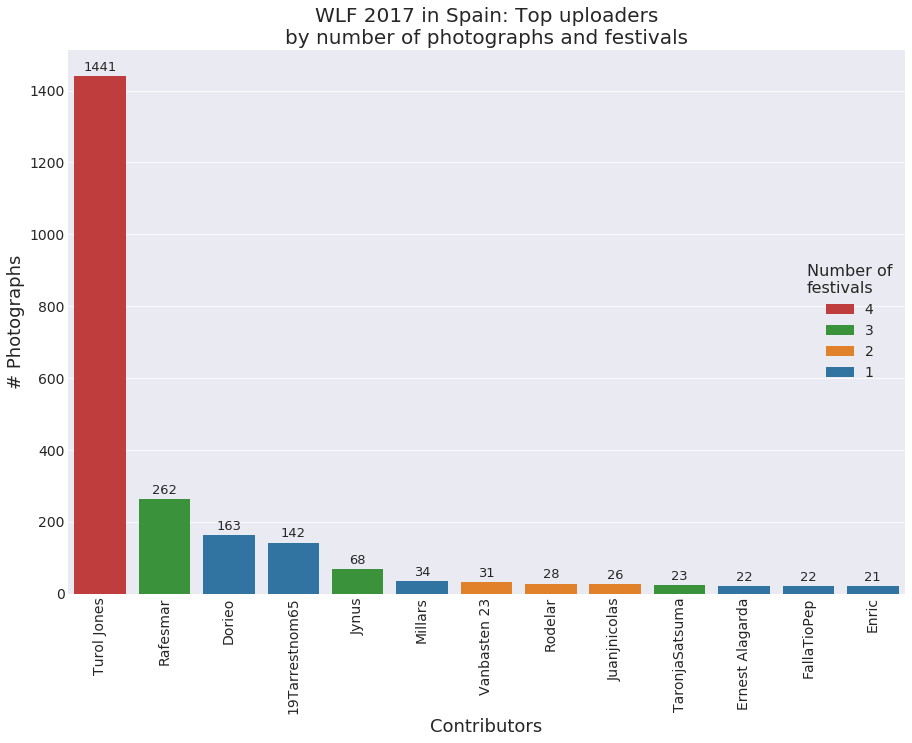

In [56]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, 
                x=uploaders_df[:TOP_UPLOADERS].index, 
                y=uploaders_df[:TOP_UPLOADERS]['Photographs'], 
                hue=uploaders_df[:TOP_UPLOADERS]['Festivals'],
                dodge=False)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top uploaders\nby number of photographs and festivals'.format(YEAR, TAG), fontsize=20)

p.tick_params(labelsize=14)
p.set_xticklabels(p.get_xticklabels(), rotation=90)

handles, labels = p.get_legend_handles_labels()
handles.reverse()
labels.reverse()

legend = plt.legend(loc='center right', 
                    title='Number of\nfestivals', 
                    fontsize=14,
                    labels=labels,
                    handles=handles)
plt.setp(legend.get_title(), fontsize=16)

for patch in p.patches:
    height = patch.get_height()
    if not math.isnan(height):
        p.text(patch.get_x() + patch.get_width()/2.,
                height + 15,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (2).png".format(YEAR, TAG),
                  'Top {2} contributors to {1} {0} in Spain with contribution to festivals'.format(YEAR, TAG_EXT, TOP_UPLOADERS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [57]:
images_df['wikidata_id'].value_counts()

Q23657061    609
Q1143768     527
Q9075892     415
Q23541308    376
Q5861379      81
Q23309364     57
Q9075846      45
Q3092925      41
Q23663100     34
Q3290365      28
Q12175110     28
Q21479929     28
Q23663119     22
Q23660880     14
Q47120057     13
Q23662027     13
Q8771143      12
Q23660934     12
Q4121017      11
Q23453449     11
              11
Q23309290     10
Q23662985      9
Q23453636      9
Q47119796      8
Q9075883       8
Q5963233       7
Q47119479      7
Q5685566       6
Q23663059      6
            ... 
Q23662044      4
Q47128318      3
Q23657189      3
Q23663612      3
Q11921892      3
Q17632299      3
Q23663605      3
Q17301586      2
Q47129466      2
Q18696203      2
Q23650279      2
Q829919        2
Q21003051      1
Q17305074      1
Q6124533       1
Q20109030      1
Q23661684      1
Q23310019      1
Q6024342       1
Q5400462       1
Q23661532      1
Q4895460       1
Q7401479       1
Q5858861       1
Q23663003      1
Q23663386      1
Q5815728       1
Q5660198      

In [58]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "autumn"]['wikidata_id'].value_counts()

Q23657061    609
Q9075892     415
Q23541308    376
Q23309364     57
Q3092925      41
Q9075846      40
Q23663100     34
Q21479929     28
Q23660880     14
Q1143768      14
Q8771143      12
Q23660934     12
Q23453449     11
Q4121017      11
Q23309290     10
Q23453636      9
Q47119796      8
Q9075883       8
Q23662985      8
Q5963233       7
Q23663059      6
Q5685566       6
Q1236370       6
Q23658027      5
Q3181317       5
Q12874         4
Q23657396      4
Q13258770      4
               4
Q17632299      3
Q23663612      3
Q47128318      3
Q23663605      3
Q23657189      3
Q11921892      3
Q23650279      2
Q17301586      2
Q829919        2
Q18696203      2
Q17305074      1
Q23310019      1
Q6024342       1
Q7401479       1
Q5858861       1
Q4895460       1
Q23661532      1
Q20109030      1
Q20105477      1
Q2918983       1
Q23661684      1
Q5660198       1
Q5815728       1
Q23663003      1
Q6124533       1
Name: wikidata_id, dtype: int64

In [59]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "summer"]['wikidata_id'].value_counts()

Q3290365     28
Q12175110    28
Q47119479     7
Q47128911     6
              3
Q23663386     1
Q1143768      1
Q21003051     1
Name: wikidata_id, dtype: int64

In [60]:
# THIS IS YEAR-DEPENDENT
images_df[images_df["campaign"] == "fallas"]['wikidata_id'].value_counts()

Q1143768     512
Q5861379      81
Q23663119     22
Q47120057     13
Q23662027     13
Q23662044      4
Q9075846       4
               4
Q47129466      2
Q23662985      1
Q5400462       1
Name: wikidata_id, dtype: int64

In [61]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df[images_df['campaign'] == 'autumn']['image_title'].resample('d').count()
upload_ts[datetime(YEAR, 11, 30)] = upload_ts[datetime(YEAR, 11, 30)] + upload_ts[datetime(YEAR, 12, 1)]
upload_ts.drop(datetime(YEAR, 12, 1), inplace=True)
upload_ts = pd.Series([0]*30, index=pd.date_range(datetime(YEAR, 11, 1), periods=30, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

2017-11-01      0
2017-11-02      0
2017-11-03      0
2017-11-04      0
2017-11-05     35
2017-11-06     22
2017-11-07      8
2017-11-08     28
2017-11-09     34
2017-11-10      2
2017-11-11     11
2017-11-12      1
2017-11-13      1
2017-11-14      0
2017-11-15      8
2017-11-16      0
2017-11-17    133
2017-11-18    301
2017-11-19    233
2017-11-20    163
2017-11-21    354
2017-11-22     39
2017-11-23    229
2017-11-24     64
2017-11-25      1
2017-11-26     64
2017-11-27      8
2017-11-28      3
2017-11-29      6
2017-11-30     61
Freq: D, dtype: int64

[[commons:File:WLF 2017 in Spain - Uploads by day (November campaign).png]]


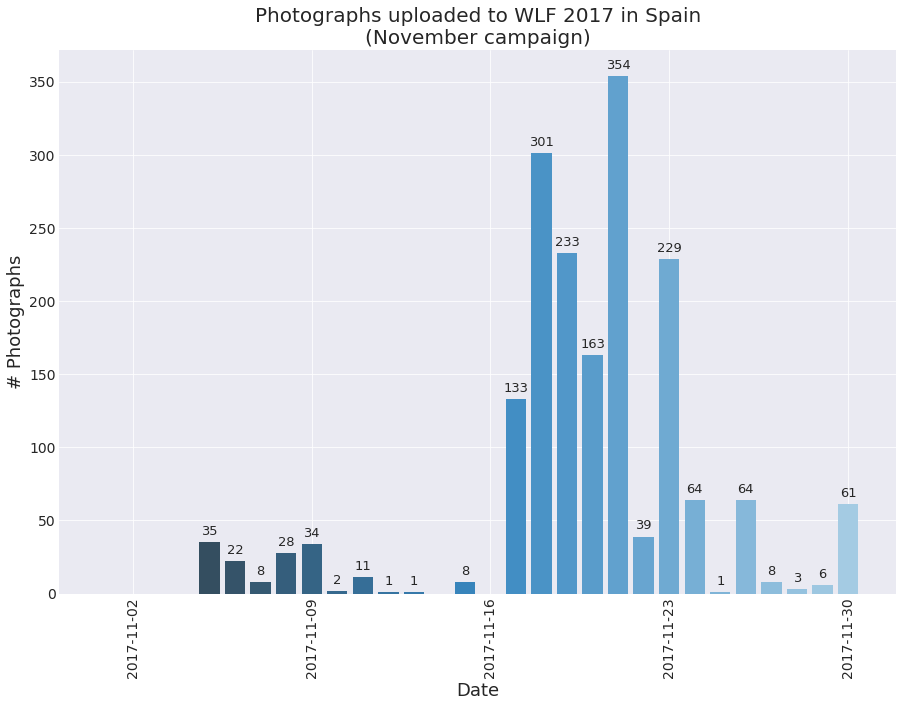

In [62]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 30))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain\n(November campaign)'.format(YEAR, TAG), fontsize=20)

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 5,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day (November campaign).png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain (November campaign) by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [63]:
# THIS IS YEAR-DEPENDENT
upload_ts = images_df[images_df['campaign'] == 'fallas']['image_title'].resample('d').count()
upload_ts = pd.Series([0]*46, index=pd.date_range(datetime(YEAR, 3, 15), periods=46, freq='D')) + upload_ts
upload_ts = upload_ts.fillna(0).astype(int)
upload_ts

2017-03-15      0
2017-03-16      0
2017-03-17      2
2017-03-18      1
2017-03-19      1
2017-03-20      0
2017-03-21      3
2017-03-22     39
2017-03-23     13
2017-03-24      0
2017-03-25     22
2017-03-26      0
2017-03-27      0
2017-03-28      0
2017-03-29      0
2017-03-30     42
2017-03-31      0
2017-04-01    171
2017-04-02      0
2017-04-03      3
2017-04-04      0
2017-04-05      1
2017-04-06      0
2017-04-07      0
2017-04-08    116
2017-04-09      0
2017-04-10      0
2017-04-11      0
2017-04-12      0
2017-04-13      0
2017-04-14      0
2017-04-15    109
2017-04-16      6
2017-04-17      2
2017-04-18      4
2017-04-19      4
2017-04-20      0
2017-04-21      0
2017-04-22      0
2017-04-23      0
2017-04-24    104
2017-04-25      0
2017-04-26      0
2017-04-27      0
2017-04-28     13
2017-04-29      0
2017-04-30      0
Freq: D, dtype: int64

[[commons:File:WLF 2017 in Spain - Uploads by day (Falles campaign).png]]


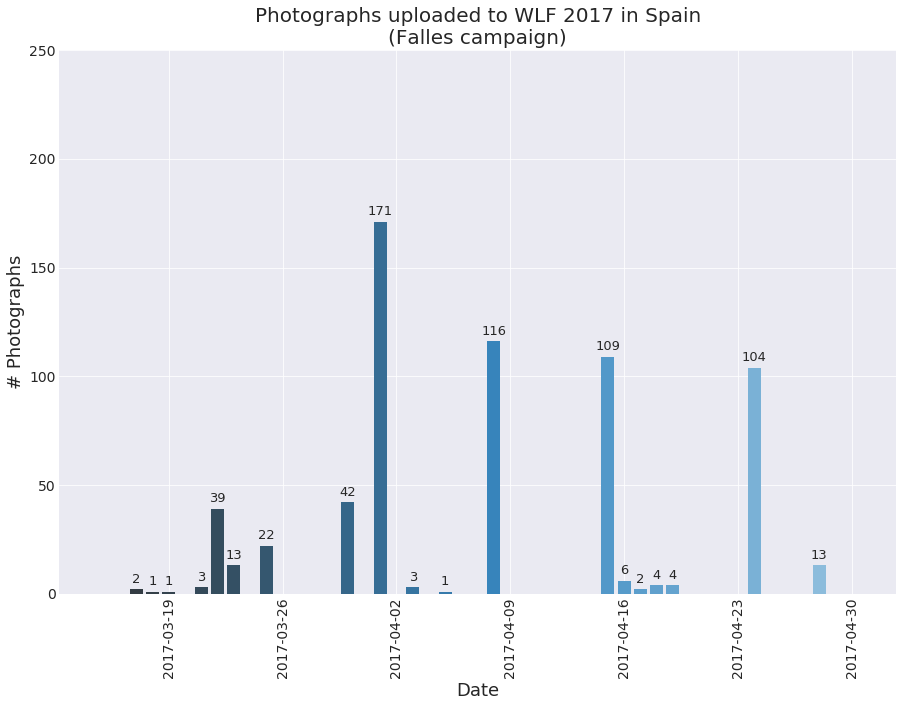

In [64]:
# THIS IS YEAR-DEPENDENT
fig, ax = plt.subplots(figsize=figsize)

p = ax.bar(upload_ts.index.to_pydatetime(), 
       upload_ts.values,
       color=sns.color_palette("Blues_d", 51))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date', fontsize=18)
ax.set_ylabel("# Photographs", fontsize=18)
ax.set_title(label='Photographs uploaded to {1} {0} in Spain\n(Falles campaign)'.format(YEAR, TAG), fontsize=20)
ax.set_ylim([0, 250])

ax.tick_params(labelsize=14)
plt.xticks(rotation=90)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0 :
        ax.text(patch.get_x() + patch.get_width()/2.,
                height + 3,
                '{:1.0f}'.format(height),
                ha="center",
                fontsize=13)

upload_to_commons(plt,
                  "{1} {0} in Spain - Uploads by day (Falles campaign).png".format(YEAR, TAG),
                  'Images uploaded to {1} {0} in Spain (Falles campaign) by day'.format(YEAR, TAG),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [65]:
images_extended_df = pd.merge(images_df, festivals_df, on='wikidata_id', how='left')
len(images_extended_df.index)

2542

In [66]:
valid_images_per_uploader = images_df[images_df['wikidata_id'].isin(valid_festivals)]['uploader'].value_counts()
valid_images_per_uploader = valid_images_per_uploader.rename('valid_images')
valid_images_per_uploader = valid_images_per_uploader.iloc[np.lexsort([valid_images_per_uploader.index, -valid_images_per_uploader.values])]
valid_images_per_uploader

Turol Jones                                1441
Rafesmar                                    234
Dorieo                                      163
Jynus                                        68
19Tarrestnom65                               59
Millars                                      34
Vanbasten 23                                 31
Juanjnicolas                                 26
Ernest Alagarda                              22
FallaTioPep                                  22
TaronjaSatsuma                               22
Enric                                        21
Rodelar                                      20
Mishifú                                      14
Pacopac                                      14
Pedro J Pacheco                              14
Jfalerog                                     13
Yumarso                                      13
Ponscor                                      12
Hameryko                                     11
Luifergim                               

In [67]:
festival_list_per_uploader = images_extended_df[images_extended_df['wikidata_id'].isin(valid_festivals)]\
                                               .groupby('uploader')['wikidata_id']\
                                               .apply(set)\
                                               .apply(lambda x: filter(None, x))\
                                               .apply(lambda x: expand_itemid(x))\
                                               .rename('festival_list', inplace=True)
festival_list_per_uploader

uploader
19Tarrestnom65                             [{'itemid': 'Q1143768', 'category': 'Falles de...
ASOCIACIÓN DE VECINOS "VIRGEN CORONADA"    [{'itemid': 'Q23662044', 'category': 'Traditio...
Andrelopesnunes2                            [{'itemid': 'Q3181317', 'category': 'La Mercè'}]
Annadctu                                   [{'itemid': 'Q1143768', 'category': 'Falles de...
Antonia Marcelo Garcia                     [{'itemid': 'Q5963233', 'category': 'La Encami...
Balablanca                                 [{'itemid': 'Q17305074', 'category': 'Irungo A...
Bgasco                                     [{'itemid': 'Q1143768', 'category': 'Falles de...
Calvesklein                                 [{'itemid': 'Q3181317', 'category': 'La Mercè'}]
Coentor                                    [{'itemid': 'Q1143768', 'category': 'Falles de...
Daviibecerril                              [{'itemid': 'Q5400462', 'category': 'Las Carre...
Dbascones                                  [{'itemid': 'Q1192

In [68]:
authors_df = pd.concat([images_per_uploader, valid_images_per_uploader, festivals_per_uploader, festival_list_per_uploader], axis=1)\
               .sort_values(by='images', ascending=False)\
               .reset_index()\
               .rename(columns = {'index': 'contestant'})

authors_df[['images', 'valid_images', 'festivals']] = authors_df[['images', 'valid_images', 'festivals']]\
                                                                        .fillna(0)\
                                                                        .astype('int')

authors_df = authors_df.iloc[np.lexsort([authors_df['contestant'], -authors_df['images']])]
authors_df['registration_string'] = authors_df['contestant'].map(lambda x: get_registration_time(x))
authors_df['festival_list'] = authors_df['festival_list'].map(lambda x: decode_list(x))
authors_df

,contestant,images,valid_images,festivals,festival_list,registration_string
0,Turol Jones,1441,1441,4,"[{'itemid': 'Q23657061', 'category': 'Bodas de...",2014-08-29
1,Rafesmar,262,234,3,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2013-09-21
2,Dorieo,163,163,1,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2008-07-20
3,19Tarrestnom65,142,59,1,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2014-02-02
4,Jynus,68,68,3,"[{'itemid': 'Q23309290', 'category': 'Holy Wee...",
5,Millars,34,34,1,"[{'itemid': 'Q23663100', 'category': 'Cavalcad...",2007-04-04
6,Vanbasten 23,31,31,2,"[{'itemid': 'Q21479929', 'category': 'Corpus d...",2007-06-16
7,Rodelar,28,20,2,"[{'itemid': 'Q23453636', 'category': 'Passion ...",2008-12-03
8,Juanjnicolas,26,26,2,"[{'itemid': 'Q23660934', 'category': 'Fiestas ...",2017-11-21
9,TaronjaSatsuma,23,22,3,"[{'itemid': 'Q1143768', 'category': 'Falles de...",2014-09-14


In [69]:
images_per_festival = images_extended_df[images_extended_df['wikidata_id'].isin(valid_festivals)]['wikidata_id'].value_counts()
images_per_festival

Q23657061    609
Q1143768     527
Q9075892     415
Q23541308    376
Q23309364     57
Q9075846      45
Q3092925      41
Q23663100     34
Q3290365      28
Q21479929     28
Q23663119     22
Q23660880     14
Q23662027     13
Q8771143      12
Q23660934     12
Q23453449     11
Q4121017      11
Q23309290     10
Q23662985      9
Q23453636      9
Q9075883       8
Q5963233       7
Q23663059      6
Q5685566       6
Q1236370       6
Q23658027      5
Q3181317       5
Q12874         4
Q23662044      4
Q13258770      4
Q23657396      4
Q17632299      3
Q23663605      3
Q23657189      3
Q23663612      3
Q11921892      3
Q17301586      2
Q829919        2
Q18696203      2
Q23650279      2
Q21003051      1
Q23661684      1
Q2918983       1
Q20109030      1
Q5400462       1
Q23661532      1
Q4895460       1
Q23663003      1
Q5815728       1
Q5660198       1
Q6124533       1
Q20105477      1
Q23663386      1
Q5858861       1
Q7401479       1
Q6024342       1
Q23310019      1
Q17305074      1
Name: wikidata

In [70]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of festivals with more than 15 pictures
TOP_FESTIVALS = 11

In [71]:
images_per_festival_df = pd.DataFrame(data=images_per_festival).reset_index()
images_per_festival_df.rename(columns={'index': 'wikidata_id', 'wikidata_id': 'count'}, inplace=True)

In [72]:
images_per_festival_df = pd.merge(images_per_festival_df, festivals_df, on='wikidata_id')[['count', 'wikidata_id', 'category', 'aut_com', 'latitude', 'longitude']].fillna('')
images_per_festival_df = images_per_festival_df.iloc[np.lexsort([images_per_festival_df['category'], -images_per_festival_df['count']])]
images_per_festival_df['category'] = images_per_festival_df['category'].map(lambda x: x.replace('_', ' '))
images_per_festival_df.head()

,count,wikidata_id,category,aut_com,latitude,longitude
0,609,Q23657061,Bodas de Isabel de Segura,Aragon,40.343611,-1.107222
1,527,Q1143768,Falles de València,Valencian Community,39.466667,-0.375000
2,415,Q9075892,Holy Week in Zaragoza,Aragon,41.650000,-0.883333
3,376,Q23541308,Holy Week in Teruel,Aragon,40.343611,-1.107222
4,57,Q23309364,"Procesión del humo, Arnedillo",La Rioja,42.211944,-2.235833


In [73]:
images_per_additional_festival = images_extended_df[images_extended_df['wikidata_id'].isin(additional_festivals)]['wikidata_id'].value_counts()
images_per_additional_festival_df = pd.DataFrame(data=images_per_additional_festival).reset_index()
images_per_additional_festival_df.rename(columns={'index': 'wikidata_id', 'wikidata_id': 'count'}, inplace=True)
images_per_additional_festival_df = pd.merge(images_per_additional_festival_df, additional_festivals_df, on='wikidata_id')[['count', 'wikidata_id', 'category', 'aut_com', 'latitude', 'longitude']].fillna('')
images_per_additional_festival_df = images_per_additional_festival_df.iloc[np.lexsort([images_per_additional_festival_df['category'], -images_per_additional_festival_df['count']])]
images_per_additional_festival_df['category'] = images_per_additional_festival_df['category'].map(lambda x: x.replace('_', ' '))
images_per_additional_festival_df['additional'] = 'additional'
images_per_additional_festival_df.head()

,count,wikidata_id,category,aut_com,latitude,longitude,additional
0,81,Q5861379,Festivals of Saint Vincent Ferrer in the city ...,Valencian Community,39.466667,-0.375000,additional
1,28,Q12175110,Gran Fira de València,Valencian Community,39.466667,-0.375000,additional
2,13,Q47120057,Falles de Dénia,Valencian Community,38.840278,0.108611,additional
3,8,Q47119796,Holy Week in Aranjuez,Community of Madrid,40.033333,-3.602778,additional
4,7,Q47119479,"Fiesta de la Virgen de Agosto y San Roque, Req...",Valencian Community,39.488538,-1.102308,additional


In [74]:
images_per_combined_festival_df = pd.concat([images_per_festival_df, images_per_additional_festival_df]).fillna('')
images_per_combined_festival_df.head()

,additional,aut_com,category,count,latitude,longitude,wikidata_id
0,,Aragon,Bodas de Isabel de Segura,609,40.343611,-1.107222,Q23657061
1,,Valencian Community,Falles de València,527,39.466667,-0.375000,Q1143768
2,,Aragon,Holy Week in Zaragoza,415,41.650000,-0.883333,Q9075892
3,,Aragon,Holy Week in Teruel,376,40.343611,-1.107222,Q23541308
4,,La Rioja,"Procesión del humo, Arnedillo",57,42.211944,-2.235833,Q23309364


In [75]:
images_per_combined_festival_df['dup_index'] = images_per_combined_festival_df.groupby(['latitude', 'longitude'])['latitude'].transform('idxmin')    
images_per_combined_festival_df['dup'] = images_per_combined_festival_df.duplicated(subset=['dup_index'])
images_per_combined_festival_df.head()

,additional,aut_com,category,count,latitude,longitude,wikidata_id,dup_index,dup
0,,Aragon,Bodas de Isabel de Segura,609,40.343611,-1.107222,Q23657061,0.0,False
1,,Valencian Community,Falles de València,527,39.466667,-0.375000,Q1143768,1.0,False
2,,Aragon,Holy Week in Zaragoza,415,41.650000,-0.883333,Q9075892,2.0,False
3,,Aragon,Holy Week in Teruel,376,40.343611,-1.107222,Q23541308,0.0,True
4,,La Rioja,"Procesión del humo, Arnedillo",57,42.211944,-2.235833,Q23309364,4.0,False


In [76]:
images_per_combined_festival_df['coordinates'] = images_per_combined_festival_df.apply(coordinate_shaker, axis=1)
images_per_combined_festival_df[['latitude', 'longitude']] = images_per_combined_festival_df['coordinates'].apply(pd.Series)
images_per_combined_festival_df.head()

,additional,aut_com,category,count,latitude,longitude,wikidata_id,dup_index,dup,coordinates
0,,Aragon,Bodas de Isabel de Segura,609,40.343611,-1.107222,Q23657061,0.0,False,"(40.343611111111116, -1.1072222222222223)"
1,,Valencian Community,Falles de València,527,39.466667,-0.375000,Q1143768,1.0,False,"(39.46666666666667, -0.375)"
2,,Aragon,Holy Week in Zaragoza,415,41.650000,-0.883333,Q9075892,2.0,False,"(41.65, -0.8833333333333333)"
3,,Aragon,Holy Week in Teruel,376,40.341676,-1.099460,Q23541308,0.0,True,"(40.34167573594632, -1.0994598564120144)"
4,,La Rioja,"Procesión del humo, Arnedillo",57,42.211944,-2.235833,Q23309364,4.0,False,"(42.21194444444445, -2.2358333333333333)"


In [77]:
images_per_combined_festival_df['geojson'] = images_per_combined_festival_df.apply(lambda row: to_geojson(row), axis=1)

In [78]:
features = images_per_combined_festival_df['geojson'].tolist()
feature_collection = FeatureCollection(features)
dump = geojson.dumps(feature_collection, ensure_ascii=False, indent=2)
#print(dump)

In [79]:
festivals_per_autcom = images_per_festival_df.groupby(['aut_com']).\
                                              count().\
                                              sort_values(by='count', ascending=False).\
                                              reset_index()[['aut_com', 'count']]
festivals_per_autcom['aut_com'] = festivals_per_autcom['aut_com'].map(lambda x: wrap_label(x, 14))
festivals_per_autcom

,aut_com,count
0,Valencian\nCommunity,12
1,Catalonia,8
2,Andalusia,5
3,Aragon,4
4,Asturias,4
5,Balearic\nIslands,4
6,Castile and\nLeón,3
7,Extremadura,3
8,La Rioja,3
9,Region of\nMurcia,3


In [80]:
aut_coms = len(festivals_per_autcom.index)
aut_coms

16

In [81]:
# THIS IS YEAR-DEPENDEND AND RELIES ON MANUAL INSPECTION
remaining_autcoms = pd.DataFrame(data=[{'aut_com': 'Castile-La Mancha', 'count':0}],
                                 index=[16])
remaining_autcoms

,aut_com,count
16,Castile-La Mancha,0


In [82]:
festivals_per_autcom = festivals_per_autcom.append(remaining_autcoms)
festivals_per_autcom

,aut_com,count
0,Valencian\nCommunity,12
1,Catalonia,8
2,Andalusia,5
3,Aragon,4
4,Asturias,4
5,Balearic\nIslands,4
6,Castile and\nLeón,3
7,Extremadura,3
8,La Rioja,3
9,Region of\nMurcia,3


[[commons:File:WLF 2017 in Spain - Festivals per autonomous community.png]]


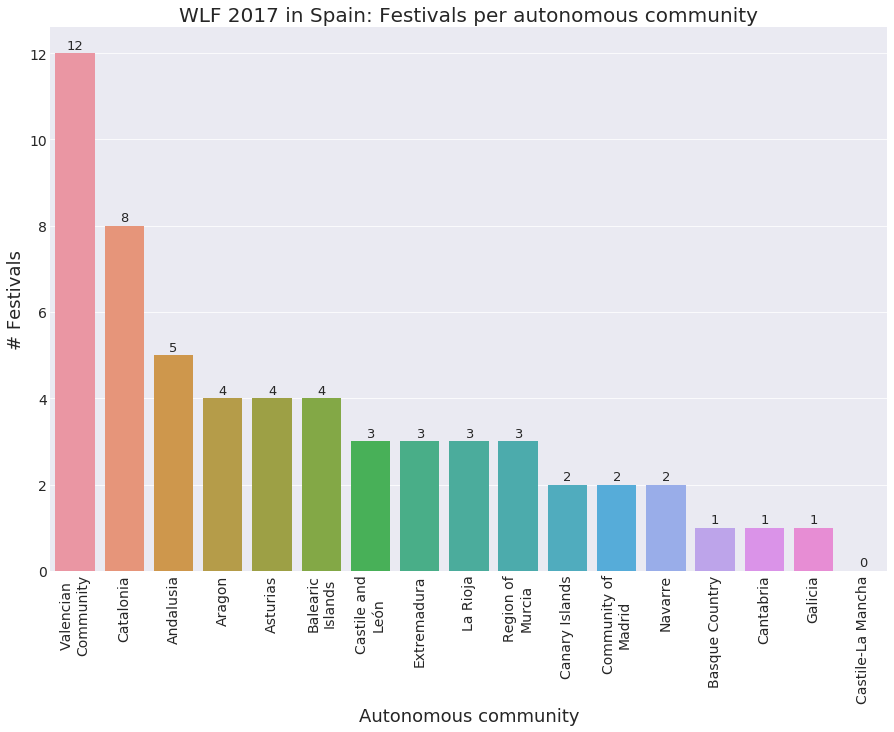

In [83]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=festivals_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous community", fontsize=18)
p.set_ylabel("# Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Festivals per autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 0.1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Festivals per autonomous community.png".format(YEAR, TAG),
                  'Catalogued festivals per autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [84]:
compact_images_per_festival = images_per_festival_df[:TOP_FESTIVALS][['count', 'category']]
compact_images_per_festival = compact_images_per_festival.iloc[np.lexsort([compact_images_per_festival['category'], -compact_images_per_festival['count']])]
compact_images_per_festival

,count,category
0,609,Bodas de Isabel de Segura
1,527,Falles de València
2,415,Holy Week in Zaragoza
3,376,Holy Week in Teruel
4,57,"Procesión del humo, Arnedillo"
5,45,Setmana Santa Marinera
6,41,Fiestas del Pilar
7,34,Cavalcade of Magi of Vila-real
9,28,Corpus de la Garriga
8,28,Festivity of La Mare de Déu de la Salut of Alg...


In [85]:
images_per_festival_df[TOP_FESTIVALS:].sum()['count']

201

In [86]:
len(images_per_festival_df[TOP_FESTIVALS:].index)

47

In [87]:
others_row = pd.DataFrame(data={'category': 'Other festivals ({0})'.format(len(images_per_festival_df[TOP_FESTIVALS:].index)),
                                'count': images_per_festival_df[TOP_FESTIVALS:].sum()['count']}, 
                          index=[TOP_FESTIVALS+1])

In [88]:
# THIS IS YEAR-DEPENDENT
no_catalogued_row = pd.DataFrame(
    data={'category': 'No catalogued festival',
          'count': len(images_extended_df[(images_extended_df['wikidata_id'] != '') & ~(images_extended_df['wikidata_id'].isin(valid_festivals))].index)},
    index=[TOP_FESTIVALS+2]
)

In [89]:
no_id_row = pd.DataFrame(data={'category': 'Unknown/invalid',
                               'count': len(images_extended_df[images_extended_df['wikidata_id'] == ''].index)}, 
                         index=[TOP_FESTIVALS+3])

In [90]:
compact_images_per_festival = compact_images_per_festival.append(others_row)
compact_images_per_festival = compact_images_per_festival.append(no_catalogued_row)
compact_images_per_festival = compact_images_per_festival.append(no_id_row)
compact_images_per_festival['category'] = compact_images_per_festival['category'].map(lambda x: wrap_label(x))
compact_images_per_festival

,category,count
0,Bodas de Isabel de Segura,609
1,Falles de València,527
2,Holy Week in Zaragoza,415
3,Holy Week in Teruel,376
4,"Procesión del humo, Arnedillo",57
5,Setmana Santa Marinera,45
6,Fiestas del Pilar,41
7,Cavalcade of Magi of Vila-real,34
9,Corpus de la Garriga,28
8,Festivity of La Mare de Déu de\nla Salut of Al...,28


[[commons:File:WLF 2017 in Spain - Top festivals.png]]


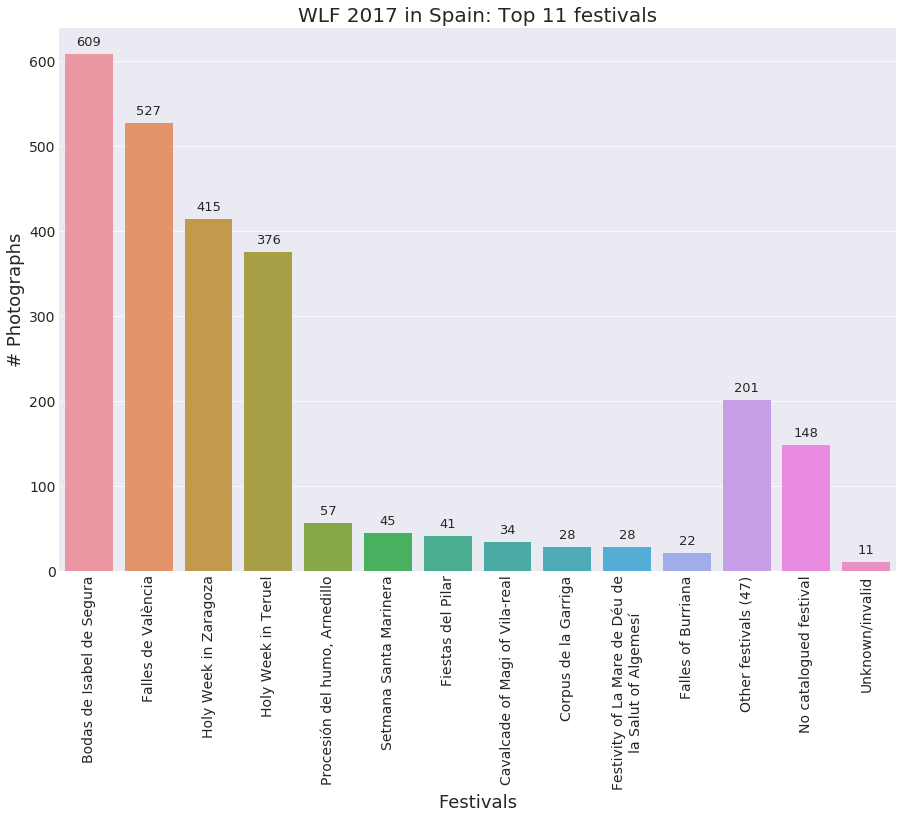

In [91]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=compact_images_per_festival, x='category', y='count')
p.set_xlabel("Festivals", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Top {2} festivals'.format(YEAR, TAG, TOP_FESTIVALS), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top festivals.png".format(YEAR, TAG),
                  'Top {2} festivals in {1} {0} in Spain'.format(YEAR, TAG_EXT, TOP_FESTIVALS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [92]:
images_per_autcom = images_per_festival_df.groupby(['aut_com']).\
                     sum().\
                     sort_values(by='count', ascending=False).\
                     reset_index()
images_per_autcom = images_per_autcom.append(remaining_autcoms)
images_per_autcom

,aut_com,count,latitude,longitude
0,Aragon,1441,163.987222,-3.981111
1,Valencian Community,681,468.056911,-6.214175
2,La Rioja,68,127.151944,-7.126944
3,Catalonia,46,332.022500,15.607500
4,Region of Murcia,32,114.372222,-3.295000
5,Extremadura,24,116.863889,-18.806944
6,Andalusia,22,185.985000,-27.585833
7,Community of Madrid,20,80.713056,-6.733056
8,Asturias,18,173.679444,-22.153611
9,Balearic Islands,11,158.635278,13.411944


[[commons:File:WLF 2017 in Spain - Photographs per autonomous community.png]]


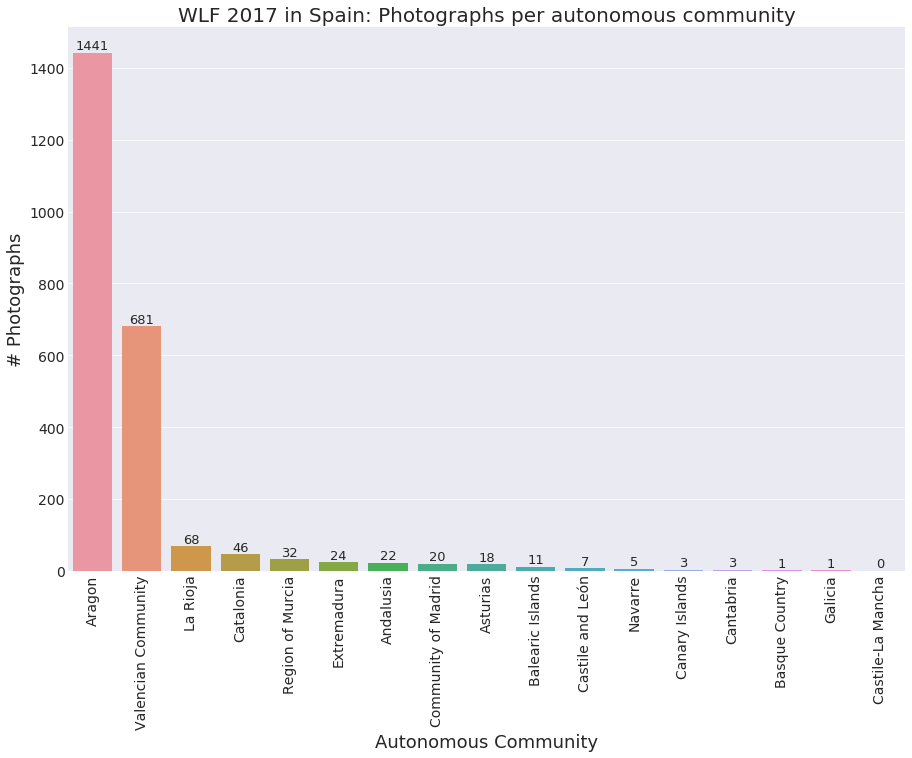

In [93]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, data=images_per_autcom, x='aut_com', y='count')
p.set_xlabel("Autonomous Community", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='{1} {0} in Spain: Photographs per autonomous community'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Photographs per autonomous community.png".format(YEAR, TAG),
                  'Photographs per autonomous community in {1} {0} in Spain'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
# usage management
n=5
list_df = [images_df[i:i+n] for i in range(0, images_df.shape[0], n)]
usage_dict = {}

counter = 0
for df in list_df :
    query_string_items = list()
    for _, row in df.iterrows():
        title = 'File:{0}'.format(row["image_title"])
        query_string_items.append(title)
    raw_api_query_string = '|'.join(query_string_items)
    MW_API_QUERY_STRING["titles"] = raw_api_query_string
    
    r = requests.post(MW_API_BASE_URL, data=urlencode(MW_API_QUERY_STRING))
    response = r.text

    try:
        response_dict = json.loads(response)
        for _, value in response_dict["query"]["pages"].items():
            uses_dict = value['globalusage']
            tuples = [(item['wiki'], 1) for item in uses_dict if (item['ns'] in VALID_NAMESPACES)]
            summary = [reduce(lambda x, y: (x[0], x[1]+y[1]), group) for _, group in groupby(sorted(tuples), key=itemgetter(0))]
            if len(summary) > 0 :
                counter +=1
                title = value['title'].replace('File:', '')
                summary_dict = {tuple[0]: tuple[1] for tuple in summary}
                usage_dict.update({title: summary_dict})
    except :
        print ('Error found')
        pass

In [ ]:
# unique images used
usage_df = pd.DataFrame(usage_dict).transpose()
total_unique=usage_df.count(axis=1).count()
total_unique

In [ ]:
# unique images used with campaign indicator
usage_campaign_df = pd.merge(usage_df.reset_index().rename(columns={'index': 'image_title'}),
                             images_df[['image_title', 'campaign']], 
                             how='inner', 
                             on='image_title')

In [ ]:
# summary table
usages_df = pd.concat([usage_df.sum(), usage_df.count()], axis=1)
usages_df.columns = ['usages', 'unique']
usages_df['usages'] = usages_df['usages'].astype(int)
usages_df.sort_values(by=['unique'], axis=0, ascending=False, inplace=True)
usages_df['name'] = usages_df.index
usages_df['name'] = usages_df['name'].map(get_project_name)
usages_df.set_index(['name'], inplace=True)
usages_df = usages_df.iloc[np.lexsort([usages_df.index, -usages_df['unique']])]
usages_df

In [ ]:
# THIS PARAMETER IS YEAR-DEPENDENT AND COMES FROM MANUAL INSPECTION
# May be set to the number of projects with more than 1 picture
TOP_PROJECTS = 14

In [ ]:
remaining_df = pd.DataFrame(usages_df.iloc[TOP_PROJECTS:].sum()).transpose()
other_projects_num = len(usages_df.index)-TOP_PROJECTS
remaining_df.index=['Other projects ({})'.format(other_projects_num)]
top_df = usages_df.iloc[:TOP_PROJECTS]
reduced_usages_df = top_df.append(remaining_df)
reduced_usages_df

In [ ]:
vf = np.vectorize(lambda x: wrap_label(x, 10))

projects = vf(reduced_usages_df.index.values)[::-1]
unique_uses = reduced_usages_df['unique'].values[::-1]
article_uses = reduced_usages_df['usages'].values[::-1]

In [ ]:
reduced_usages_df.index.values

In [1]:
y = np.arange(article_uses.size)
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=figsize_mid)
pylab.gcf().suptitle('Unique photographs from {2} {0} in Spain used in Wikimedia projects ({1})'.format(YEAR, now, TAG), 
                     fontsize=20, 
                     y=1.04)

axes[0].barh(y, unique_uses, align='center', color=sns.color_palette())
axes[0].set_title('# Unique photographs', fontsize=16)
axes[1].barh(y, article_uses, align='center', color=sns.color_palette())
axes[1].set_title('# Articles with photographs', fontsize=16)

axes[0].invert_xaxis()
axes[0].set_yticks(y)
axes[0].set_yticklabels(projects, horizontalalignment="center", fontsize=12)
axes[0].tick_params(axis='y', which='major', pad=44)
axes[0].yaxis.tick_right()
axes[0].set_xlim(130)

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)
    
for patch in axes[1].patches:
    ax.text(patch.get_width() + 1,
            patch.get_y()+patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            va="center",
            fontsize=14)

for patch in axes[0].patches:
    ax.text(-28-(patch.get_width()*1.04),
            patch.get_y()+patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            va="center",
            fontsize=14)

fig.tight_layout()
fig.subplots_adjust(wspace=0.18)

upload_to_commons(fig,
                  "{1} {0} in Spain - Photographs used in WMF projects.png".format(YEAR, TAG),
                  'Photographs from {1} {0} in Spain used in WMF projects: top {2} projects'.format(YEAR, TAG_EXT, TOP_PROJECTS),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

NameError: name 'np' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='unique', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label='Unique photographs from {2} {0} in Spain used in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
'''upload_to_commons(p,
                  "{1} {0} in Spain - Unique photographs used in WMF projects.png".format(YEAR, TAG),
                  'Unique photographs from {1} {0} in Spain used in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x='index', y='usages', data=reduced_usages_df.reset_index())
p.set_xlabel("Project", fontsize=18)
p.set_ylabel("# Uses", fontsize=18)

p.set_title(label='Uses of photographs from {2} {0} in Spain in Wikimedia projects\n({1})'.format(YEAR, now, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)
    
'''upload_to_commons(p,
                  "{1} {0} in Spain - Uses of photographs in WMF projects.png".format(YEAR, TAG),
                  'Uses of photographs from {1} {0} in Spain in WMF projects: top 12 projects'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
# Quality images gallery
template = """This page lists the ${len(QI_list)} '''[[Commons:Quality Images|quality images]]''' uploaded as part of the 
[[Commons:${tag}|${tag}]] contest in ${year} in Spain.

<gallery>
% for image in QI_list:
${image}
% endfor
</gallery>

'''Statistics generation date''': {{subst:CURRENTMONTHNAME}} {{subst:CURRENTDAY}}, {{subst:CURRENTYEAR}}

[[Category:${tag} in Spain| Quality]]

"""
vars = {
    "QI_list": qi_list.values,
    "tag": TAG_EXT,
    "year": YEAR
}
t = Template(template)
qi_gallery_text = t.render(**vars)

In [ ]:
qi_page = pb.Page(commons_site, GALLERY_QI)
if qi_page.text != qi_gallery_text:
    qi_page.text = qi_gallery_text
    pb.output('Publishing --> {1} {0} in Spain featured articles gallery'.format(YEAR, TAG))
    qi_page.save("{1} {0} in Spain featured articles gallery".format(YEAR, TAG))

#### Finalists

In [ ]:
cat_wlf = pb.Category(commons_site, WLF_FINALIST_CATEGORY)
gen_wlf = pagegenerators.CategorizedPageGenerator(cat_wlf)

finalist_images_wlf = [page.title(withNamespace=False) for page in gen_wlf if page.is_filepage()]
finalist_images_count = len(finalist_images_wlf)
finalist_images_count

In [ ]:
finalist_images_df = images_extended_df[images_extended_df['image_title'].isin(finalist_images_wlf)]
finalist_authors = finalist_images_df['uploader'].value_counts()
finalist_authors = finalist_authors.iloc[np.lexsort([finalist_authors.index, -finalist_authors.values])]
finalist_authors

In [ ]:
finalist_authors_count = len(finalist_authors)
finalist_authors_count

In [ ]:
fig, ax = plt.subplots(figsize=figsize_high)

p = sns.barplot(ax=ax, y=finalist_authors.index.map(lambda x: wrap_label(x, 20)), x=finalist_authors.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Contestants", fontsize=18)

p.set_title(label='{1} {0} in Spain: Finalists'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalists.png".format(YEAR, TAG),
                  'Top contributors reaching the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
finalist_festivals = finalist_images_df['category'].value_counts()
finalist_festivals = finalist_festivals.iloc[np.lexsort([finalist_festivals.index, -finalist_festivals.values])]
finalist_festivals

In [ ]:
fig, ax = plt.subplots(figsize=figsize_high)

p = sns.barplot(ax=ax, y=finalist_festivals.index.map(lambda x: wrap_label(x, 20)), x=finalist_festivals.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Festivals in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist festivals.png".format(YEAR, TAG),
                  'Top festivals in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
finalist_campaigns = finalist_images_df['campaign'].value_counts()
finalist_campaigns

In [ ]:
fig, ax = plt.subplots(figsize=figsize_low)

p = sns.barplot(ax=ax, y=finalist_campaigns.index, x=finalist_campaigns.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Campaigns in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

p.set_yticklabels(['November', 'Falles', 'Summer'])

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist campaigns.png".format(YEAR, TAG),
                  'Campaigns in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

In [ ]:
finalist_autcoms = finalist_images_df['aut_com'].value_counts()
finalist_autcoms = finalist_autcoms.iloc[np.lexsort([finalist_autcoms.index, -finalist_autcoms.values])]
finalist_autcoms

In [ ]:
fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, y=finalist_autcoms.index.map(lambda x: wrap_label(x, 14)), x=finalist_autcoms.values)
p.set_xlabel("# Photographs", fontsize=18)
p.set_ylabel("Festivals", fontsize=18)

p.set_title(label='{1} {0} in Spain: Autonomous communities in the final round'.format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

for patch in ax.patches:
    ax.text(patch.get_width() + 1,
            patch.get_y() + patch.get_height()/2.,
            '{:1.0f}'.format(patch.get_width()),
            ha="center",
            fontsize=14)

upload_to_commons(p,
                  "{1} {0} in Spain - Finalist autonomous communities.png".format(YEAR, TAG),
                  'Spanish autonomous communities in the final round of {1} {0} in Spain.'.format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )

#### Specific content

In [ ]:
coverage_totals = festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['aut_com'].count()
coverage_category = festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['category'].count()
coverage_images = festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['image'].count()

coverage_df = pd.concat([festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['aut_com'].count(),
                        festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['category'].count(),
                        festivals_df[['aut_com', 'category', 'image']].groupby(['aut_com'])['image'].count(), annexes], axis=1)

total_coverage = coverage_df.sum(numeric_only=True).rename('Total')
coverage_df = coverage_df.append(total_coverage)

coverage_df['aut_com'] = coverage_df['aut_com'].fillna(0).astype('int')
coverage_df['category_percentage'] = (100.*coverage_df['category']/coverage_df['aut_com']).round(2)
coverage_df['image_percentage'] = (100.*coverage_df['image']/coverage_df['aut_com']).round(2)
coverage_df['category'] = coverage_df['category'].fillna(0).astype('int')
coverage_df['image'] = coverage_df['image'].fillna(0).astype('int')
coverage_df['image_color'] = coverage_df['image_percentage'].apply(heat_color)
coverage_df['cat_color'] = coverage_df['category_percentage'].apply(heat_color)

In [ ]:
coverage_df

In [ ]:
images_c01_df = images_df[images_df['campaign'] == 'fallas']
images_c01_per_uploader = images_c01_df['uploader'].value_counts()
images_c01_per_uploader = images_c01_per_uploader.rename('images')
images_c01_per_uploader = images_c01_per_uploader.iloc[np.lexsort([images_c01_per_uploader.index, -images_c01_per_uploader.values])]

remaining_images_c01_per_uploader_count = images_c01_per_uploader[15:].count()

remaining_images_c01_per_uploader_sum = images_c01_per_uploader[15:].sum()

remaining_images_c01_per_uploader = images_c01_per_uploader[:15]
remaining_images_c01_per_uploader = remaining_images_c01_per_uploader.iloc[np.lexsort([remaining_images_c01_per_uploader.index, -remaining_images_c01_per_uploader.values])]
remaining_images_c01_per_uploader = remaining_images_c01_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_c01_per_uploader_count): remaining_images_c01_per_uploader_sum}))

In [ ]:
'''fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_c01_per_uploader.index, y=remaining_images_c01_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label="{1} {0} in Spain ('Falles' campaign): Top uploaders".format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors ('Falles' campaign).png".format(YEAR, TAG),
                  "Top 15 contributors to {1} {0} (''Falles'' campaign) in Spain".format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
images_c02_df = images_df[images_df['campaign'] == 'summer']
images_c02_per_uploader = images_c02_df['uploader'].value_counts()
images_c02_per_uploader = images_c02_per_uploader.rename('images')
images_c02_per_uploader = images_c02_per_uploader.iloc[np.lexsort([images_c02_per_uploader.index, -images_c02_per_uploader.values])]

In [ ]:
'''fig, ax = plt.subplots(figsize=figsize_half)

p = sns.barplot(ax=ax, x=images_c02_per_uploader.index, y=images_c02_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label="{1} {0} in Spain (Summer campaign):\nTop uploaders".format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 1,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (Summer campaign).png".format(YEAR, TAG),
                  "Top contributors to {1} {0} (Summer campaign) in Spain".format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
images_c03_df = images_df[images_df['campaign'] == 'autumn']
images_c03_per_uploader = images_c03_df['uploader'].value_counts()
images_c03_per_uploader = images_c03_per_uploader.rename('images')
images_c03_per_uploader = images_c03_per_uploader.iloc[np.lexsort([images_c03_per_uploader.index, -images_c03_per_uploader.values])]

remaining_images_c03_per_uploader_count = images_c03_per_uploader[12:].count()
remaining_images_c03_per_uploader_sum = images_c03_per_uploader[12:].sum()

remaining_images_c03_per_uploader = images_c03_per_uploader[:12]
remaining_images_c03_per_uploader = remaining_images_c03_per_uploader.iloc[np.lexsort([remaining_images_c03_per_uploader.index, -remaining_images_c03_per_uploader.values])]
remaining_images_c03_per_uploader = remaining_images_c03_per_uploader.append(pd.Series(data={"Rest ({0})".format(remaining_images_c03_per_uploader_count): remaining_images_c03_per_uploader_sum}))

In [ ]:
'''fig, ax = plt.subplots(figsize=figsize)

p = sns.barplot(ax=ax, x=remaining_images_c03_per_uploader.index, y=remaining_images_c03_per_uploader.values)
p.set_xlabel("Contributors", fontsize=18)
p.set_ylabel("# Photographs", fontsize=18)

p.set_title(label="{1} {0} in Spain (November campaign): Top uploaders".format(YEAR, TAG), fontsize=20)
p.tick_params(labelsize=14)

p.set_xticklabels(p.get_xticklabels(), rotation=90)

for patch in p.patches:
    height = patch.get_height()
    p.text(patch.get_x() + patch.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            fontsize=13)

upload_to_commons(p,
                  "{1} {0} in Spain - Top authors (Regular campaign).png".format(YEAR, TAG),
                  "Top 12 contributors to {1} {0} (November campaign) in Spain".format(YEAR, TAG_EXT),
                  plot_description,
                  YEAR,
                  TAG_EXT
                 )'''

In [ ]:
template_stat_page = os.path.join(templates_directory, 'wlf{0}.wiki'.format(YEAR))
fh = open(template_stat_page, 'r', encoding = "utf-8")
template = fh.read()
fh.close()

In [ ]:
vars = {
    "images_length": total_images_length,
    "valid_images_length": valid_images_length,
    "festival_images_length": 0,
    "qi_length": qi_length,
    "gallery_quality_images": GALLERY_QI,
    "wlf_festivals_length": wlf_festivals_length,
    "authors_length": authors_length,
    "new_uploaders_length": new_uploaders_length,
    "festival_length": festival_length,
    "aut_coms": aut_coms,
    "authors_df": authors_df,
    "images_per_festival_df": images_per_festival_df,
    "usages_df": usages_df,
    "coverage_df": coverage_df,
    "total_unique": total_unique,
    "new_uploaders": new_uploaders,
    "new_uploaders_sum": new_uploaders.sum(),
    "campaign_count": campaign_count,
    "finalist_images_count": finalist_images_count,
    "finalist_authors_count": finalist_authors_count,
    "annexes": {i[1]: i[0] for i in festival_annexes},
    "map": dump,
    "year": YEAR,
    "tag": TAG,
    "full_tag": TAG_EXT,
    "base": BASE_WLF_NAME,
    "stats_2016": BASE_WLF2016_NAME + "/Stats"
}
t = Template(template)
statisticts_text = t.render(**vars)

In [ ]:
stats_page = pb.Page(commons_site, STATISTICS_PAGE)
stats_page.text = statisticts_text
pb.output('Publishing --> {1} {0} in Spain Statistics'.format(YEAR, TAG))
stats_page.save("{1} {0} in Spain statistics".format(YEAR, TAG))